In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.ndimage
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner import HyperModel, RandomSearch

from spatialinfo import spatial_information as si
from spatialinfo import basis_decoder as bd

- [Introduction](#location-decoding-from-population-activity) 
- [ANN](#build-and-run-the-model)
- [Basis Decoder](#direct-basis-decoder)

# Location Decoding From Population Activity

This notebook extends the analysis of neural activity data (2P calcium imaging) of adult zebrafish moving through a virtual reality (1D corridors). Here, the amount of information encoded in the population activity will be measured. Secondly, the position of the fish within the VR will be decoded from activity data by different statistical procedures. 

1. Mututal information between single neuron activity and location of the animal
2. Logistic classifier for the corridors based on neural activity

Regarding the first point, one approach would be to calculate the information gain for each feature (i.e., activity of each neuron). One could construct the problem at hand as a classification problem, where our input vector is

$X_i = \begin{bmatrix} \lambda_1 \\\ \lambda_2 \\\ \lambda_3 \\\ \lambda_{...} \\\ \lambda_j \end{bmatrix}$, with $\lambda_{1-j}$ being the averaged activity of each neuron for space bin i. The output vector might then take the form of 

$Y_i = \begin{bmatrix} corridor \\\ bin_i \end{bmatrix}$ or $Y_i =  bin_i^{corridor}$

### Input Files
We are using the following data structure: 
```
processed_datasets/
├── yyyymmdd_Area_AcqNr/
│   ├── yyyymmdd_Area_AcqNr_dff.pkl
│   ├── yyyymmdd_Area_AcqNr_behavior.pkl
```

These .pkl files contain activity data for all neurons in a given dataset ($\Delta F/F_0$ normalized) and the position of the fish in the virtual reality (X and Y columns for spatial information and frdIn for tailbeat intensity).


### Pre-processing
Initially, we follow the steps outlined in the notebook on [spatial information coding](SpatialInformationCoding.ipynb). 

1. We discretize the behavioral data into spatial bins tiling the two corridors.
2. We compute the average activity matrix that contains the average activity per neuron per spatial bin.
3. This dataset will be min/max normalized for each neuron.
4. From here, we obtain the input/output pairs with an activity vector of all neurons for a given space bin as the input and the identity of the space bin as the output.





### References

https://www.geeksforgeeks.org/information-gain-and-mutual-information-for-machine-learning/

We first load the data, add the trial column to the behavior dataset and compute the multi-index dataframe. Then, we build input and output vectors.

In [2]:
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
results_df = si.trials_over_time(dff, bh, n_bins=30) # 30

X, (y_bins, y_corridors) = si.format_for_ann(results_df)

Classically, the data is split in train and test set: 

In [3]:
# Split the data
X_train, X_test, y_bins_train, y_bins_test, y_corridors_train, y_corridors_test = train_test_split(
    X, y_bins, y_corridors, test_size=0.1, random_state=42, stratify=y_bins  # Stratify by bins
)

# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_bins_train shape:", y_bins_train.shape)
print("y_bins_test shape:", y_bins_test.shape)
print("y_corridors_train shape:", y_corridors_train.shape)
print("y_corridors_test shape:", y_corridors_test.shape)

# Check class balance
corridor_counts = pd.Series(y_corridors).value_counts()
print("Corridor Distribution:\n", corridor_counts)

# Check bin distribution
bin_counts = pd.Series(y_bins).value_counts()
print("Bin Distribution:\n", bin_counts)

X_train shape: (807, 366)
X_test shape: (90, 366)
y_bins_train shape: (807,)
y_bins_test shape: (90,)
y_corridors_train shape: (807,)
y_corridors_test shape: (90,)
Corridor Distribution:
 1    498
0    399
Name: count, dtype: int64
Bin Distribution:
 0     42
1     40
2     40
3     37
5     37
4     36
6     34
7     32
12    30
13    30
15    30
16    30
8     30
14    29
17    29
9     29
10    29
11    29
19    29
20    28
21    27
18    27
23    27
24    27
22    27
25    25
29    22
26    22
28    22
27    21
Name: count, dtype: int64


## Build and run the model

In [4]:
def build_keras_model(input_size, n_bins, n_corridors):
    inputs = tf.keras.Input(shape=(input_size,))
    
    # Shared layers
    x = layers.Dense(128, activation="relu")(inputs) # 128
    x = layers.Dense(64, activation="relu")(x) # 64
    

    # Two separate outputs
    bin_output = layers.Dense(n_bins, activation="softmax", name="bin_output")(x)
    corridor_output = layers.Dense(n_corridors, activation="softmax", name="corridor_output")(x)

    model = models.Model(inputs=inputs, outputs=[bin_output, corridor_output])
    
    model.compile(optimizer="adam",
                  loss={"bin_output": "sparse_categorical_crossentropy",
                        "corridor_output": "sparse_categorical_crossentropy"},
                  metrics={"bin_output": ["accuracy"],
                           "corridor_output": ["accuracy"]})  # Fix: Separate metrics
    
    return model

# Build and train the model
keras_model = build_keras_model(input_size=X.shape[1], n_bins=30, n_corridors=2)
keras_model.fit(X_train, {"bin_output": y_bins_train, "corridor_output": y_corridors_train}, epochs=200, batch_size=64)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - bin_output_accuracy: 0.0235 - bin_output_loss: 3.4613 - corridor_output_accuracy: 0.5599 - corridor_output_loss: 0.6888 - loss: 4.1501  
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bin_output_accuracy: 0.0436 - bin_output_loss: 3.4056 - corridor_output_accuracy: 0.5666 - corridor_output_loss: 0.6678 - loss: 4.0737 
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bin_output_accuracy: 0.0365 - bin_output_loss: 3.3962 - corridor_output_accuracy: 0.5778 - corridor_output_loss: 0.6765 - loss: 4.0726 
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bin_output_accuracy: 0.0495 - bin_output_loss: 3.3847 - corridor_output_accuracy: 0.6721 - corridor_output_loss: 0.6569 - loss: 4.0416 
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - bin_output_accuracy: 0.0417 - bin_output_loss: 3.3826 - corridor_output_accuracy: 0.6230 - corridor_output_loss: 0.6421 - loss: 4.0245 
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - b

In [5]:
# Get model predictions on the test set
y_pred_bins, y_pred_corridors = keras_model.predict(X_test)

# Convert probabilities to class labels
y_pred_bins = np.argmax(y_pred_bins, axis=1)  # Get the highest probability bin
y_pred_corridors = np.argmax(y_pred_corridors, axis=1)  # Get highest probability corridor

# Compute accuracy
bin_accuracy = accuracy_score(y_bins_test, y_pred_bins)
corridor_accuracy = accuracy_score(y_corridors_test, y_pred_corridors)

print(f"Bin Classification Accuracy: {bin_accuracy:.4f}")
print(f"Corridor Classification Accuracy: {corridor_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Bin Classification Accuracy: 0.3333
Corridor Classification Accuracy: 0.9333


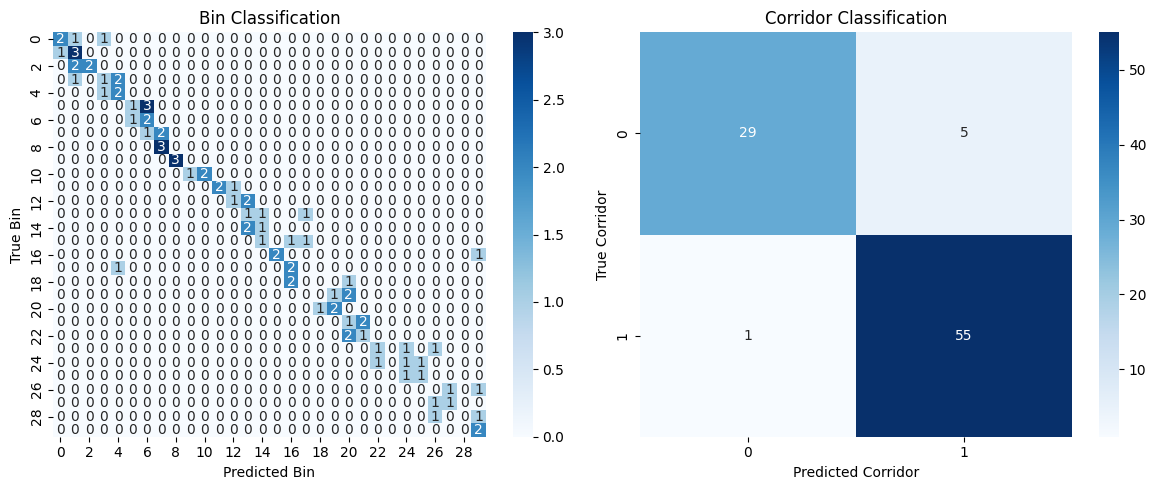

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bin classification confusion matrix
sns.heatmap(conf_matrix_bins, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_xlabel("Predicted Bin")
ax1.set_ylabel("True Bin")
ax1.set_title("Bin Classification")

# Corridor classification confusion matrix
sns.heatmap(conf_matrix_corridors, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[0, 1], yticklabels=[0, 1], ax=ax2)
ax2.set_xlabel("Predicted Corridor")
ax2.set_ylabel("True Corridor")
ax2.set_title("Corridor Classification")

plt.tight_layout()
plt.show()


In [13]:
# Print classification reports
print("Classification Report - Bin Classification:")
print(classification_report(y_bins_test, y_pred_bins))

print("Classification Report - Corridor Classification:")
print(classification_report(y_corridors_test, y_pred_corridors))

Classification Report - Bin Classification:
              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.50      0.50      0.50         4
           2       0.50      0.25      0.33         4
           3       0.25      0.50      0.33         4
           4       0.00      0.00      0.00         4
           5       0.50      0.50      0.50         4
           6       0.25      0.33      0.29         3
           7       0.33      0.67      0.44         3
           8       0.00      0.00      0.00         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         3
          11       0.40      0.67      0.50         3
          12       0.00      0.00      0.00         3
          13       0.33      0.33      0.33         3
          14       1.00      0.33      0.50         3
          15       0.00      0.00      0.00         3
          16       0.11      0.33    

c:\Users\lukas\anaconda3\envs\SpatialInformation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lukas\anaconda3\envs\SpatialInformation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lukas\anaconda3\envs\SpatialInformation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [14]:
def proximity_weighted_accuracy(y_true, y_pred, max_distance=2):
    """
    Compute accuracy where predictions closer to the true bin get partial credit.

    Parameters:
        y_true (array-like): True bin labels.
        y_pred (array-like): Predicted bin labels.
        max_distance (int): Maximum distance for partial credit.

    Returns:
        float: Proximity-weighted accuracy score.
    """
    total_score = 0
    for true, pred in zip(y_true, y_pred):
        distance = abs(true - pred)
        if distance <= max_distance:
            total_score += 1 - (distance / (max_distance + 1))
    
    return total_score / len(y_true)

# Evaluate proximity-weighted accuracy
proximity_acc = proximity_weighted_accuracy(y_bins_test, y_pred_bins)
print(f"Proximity-Weighted Accuracy: {proximity_acc:.4f}")

Proximity-Weighted Accuracy: 0.6886


It would be interesting to deduce how much information individual features (=neurons) contribute in the classification task. To compute these values, I combine bin and corridor in a joint score:

In [10]:
y_combined = y_bins + y_corridors * (max(y_bins) + 1)
# Calculate Mutual Information using mutual_info_regression
mutual_info = mutual_info_regression(X, y_combined)

Another aspect to look at is the _information gain_ we receive when we include any given feature in the classification task. 

Text(0, 0.5, 'Density')

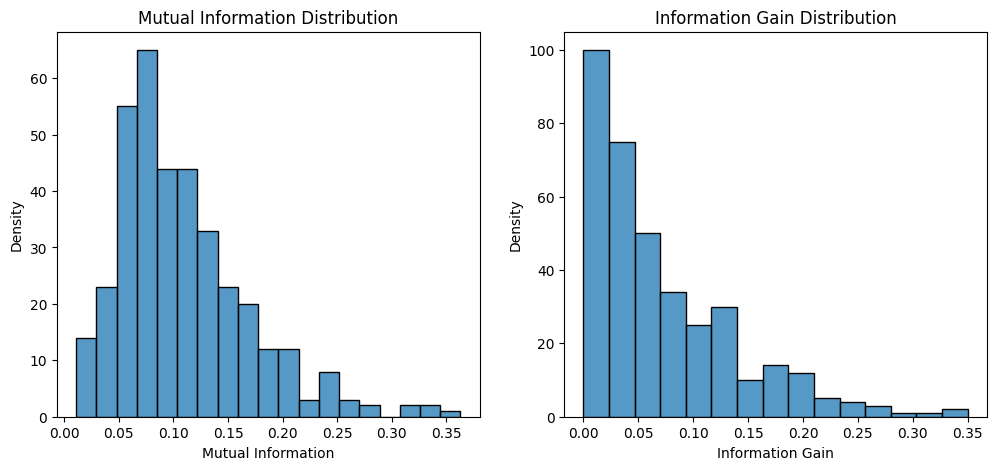

In [12]:

# Calculate Information Gain using mutual_info_classif
info_gain = mutual_info_classif(X, y_combined)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(mutual_info, ax=ax1)
ax1.set_title("Mutual Information Distribution")
ax1.set_xlabel("Mutual Information")
ax1.set_ylabel("Density")

sns.histplot(info_gain, ax=ax2)
ax2.set_title("Information Gain Distribution")
ax2.set_xlabel("Information Gain")
ax2.set_ylabel("Density")

## Direct Basis Decoder

The ANN above is not the gold standard for position decoding in the spatial navigation field. For example, in the [Yang et al. paper from 2024](https://www.nature.com/articles/s41586-024-07867-2), the authors used a direct basis decoder as described below (adapted from their M&M section):

"*The direct basis decoder is a linear decoder with no free parameters that predicts the animal’s position at each individual time point by a linear combination of the spatial activity maps, weighted with the activity of the corresponding place-encoding cell. [...] Even though no parameters had to be learned, it is still necessary to compute the spatial activity map of each cell. To avoid circularity between computing the spatial activity map and testing the decoder we used a cross-validation scheme in which the neural data were divided into [trials]. To test the decoder on each [trial] we first computed the spatial activity map without including the test [trial] or its two neighbouring [trials]. The predictions of all [trials] were concatenated as the prediction of the whole dataset. Decoder error was then computed as the mean distance between the predicted and actual position of the fish across the dataset. Spatial activity maps were constructed as described above using spatial bins (side length [5 VR units]) [...]. All maps were standardized by mean and standard deviation. To prepare the decoder, [...] maps of the most active 30% of cells were weighted by their respective activity and summed to form the decoder map.*"

This method was originally introduced by [Zhang et al., 1998](https://journals.physiology.org/doi/full/10.1152/jn.1998.79.2.1017). 

According to their description, basis function methods rely on the linear combination of basis functions (or fixed templates), with the coefficients in the linear combination being proportional to the activity of the neuron at the time point in question. 

$$
\displaystyle\sum_{i} n_{i} * \phi_{i}(x)
$$
is the distribution over physical space, indexed by x. The peak value of this distribution is taken as the reconstructed position 
$$
\hat{x} = \arg\max_{x} \sum_{i} n_{i} * \phi_{i}(x)
$$

To create the fixed templates, the above defined functions will be used:
- binning()
- avg_activity()


Additionally, 
- add regression
- create sliding window function to cross-validate

In [56]:
# load data, pre-process, construct activity matrices
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
time_per_bin, summed_traces, _ = si.binning(dff, bh, n_bins=30)
avg_act_mtx = si.avg_activity(time_per_bin, summed_traces)

len(time_per_bin)

30

In [63]:
len(np.unique(bh.trial + bh.Y_bin))

67

The IDs of spatially selective neurons have been pre-computed for the test data files, here: 20240903_Dc_1. 

1, 6, 8, 13, 17, 18, 20, 21, 42, 45, 52, 58, 59, 72, 73, 81, 83,
       99, 106, 112, 129, 136, 153, 172, 179, 188, 195, 197, 198, 204,
       210, 211, 232, 254, 275, 278, 285, 286, 292, 301, 311, 318, 320,
       321, 329, 337, 338, 346

Test whether the basis decoder works better with only place cells as input. 

In [13]:
ID_20240903_Dc_1 = np.array([1, 6, 8, 13, 17, 18, 20, 21, 42, 45, 52, 58, 59, 72, 73, 81, 83,
       99, 106, 112, 129, 136, 153, 172, 179, 188, 195, 197, 198, 204,
       210, 211, 232, 254, 275, 278, 285, 286, 292, 301, 311, 318, 320,
       321, 329, 337, 338, 346])

print(dff.shape)
dff_subset = dff.iloc[:, ID_20240903_Dc_1]
print(dff_subset.shape)

dff_subset.columns = range(dff_subset.shape[1])

(56000, 366)
(56000, 48)


In [14]:
df = bd.fixed_template(dff, bh)

df_subset = bd.fixed_template(dff_subset, bh)

Performing LOOCV on trial 0.
Performing LOOCV on trial 1.
Performing LOOCV on trial 2.
Performing LOOCV on trial 3.
Performing LOOCV on trial 4.
Performing LOOCV on trial 5.
Performing LOOCV on trial 6.
Performing LOOCV on trial 7.
Performing LOOCV on trial 8.
Performing LOOCV on trial 9.
Performing LOOCV on trial 10.
Performing LOOCV on trial 11.
Performing LOOCV on trial 12.
Performing LOOCV on trial 13.
Performing LOOCV on trial 14.
Performing LOOCV on trial 15.
Performing LOOCV on trial 16.
Performing LOOCV on trial 17.
Performing LOOCV on trial 18.
Performing LOOCV on trial 19.
Performing LOOCV on trial 20.
Performing LOOCV on trial 21.
Performing LOOCV on trial 22.
Performing LOOCV on trial 23.
Performing LOOCV on trial 24.
Performing LOOCV on trial 25.
Performing LOOCV on trial 26.
Performing LOOCV on trial 27.
Performing LOOCV on trial 28.
Performing LOOCV on trial 29.
Performing LOOCV on trial 30.
Performing LOOCV on trial 31.
Performing LOOCV on trial 32.
Performing LOOCV on 

D:\projects\SpatialInformation\src\spatialinfo\spatial_information.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.
  5. 

Performing LOOCV on trial 39.
Performing LOOCV on trial 40.
Performing LOOCV on trial 41.
Performing LOOCV on trial 0.
Performing LOOCV on trial 1.
Performing LOOCV on trial 2.
Performing LOOCV on trial 3.
Performing LOOCV on trial 4.
Performing LOOCV on trial 5.
Performing LOOCV on trial 6.
Performing LOOCV on trial 7.
Performing LOOCV on trial 8.
Performing LOOCV on trial 9.
Performing LOOCV on trial 10.
Performing LOOCV on trial 11.
Performing LOOCV on trial 12.
Performing LOOCV on trial 13.
Performing LOOCV on trial 14.
Performing LOOCV on trial 15.
Performing LOOCV on trial 16.
Performing LOOCV on trial 17.
Performing LOOCV on trial 18.
Performing LOOCV on trial 19.
Performing LOOCV on trial 20.
Performing LOOCV on trial 21.
Performing LOOCV on trial 22.
Performing LOOCV on trial 23.
Performing LOOCV on trial 24.
Performing LOOCV on trial 25.
Performing LOOCV on trial 26.
Performing LOOCV on trial 27.
Performing LOOCV on trial 28.
Performing LOOCV on trial 29.
Performing LOOCV on 

D:\projects\SpatialInformation\src\spatialinfo\spatial_information.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.
  5. 

Performing LOOCV on trial 39.
Performing LOOCV on trial 40.
Performing LOOCV on trial 41.


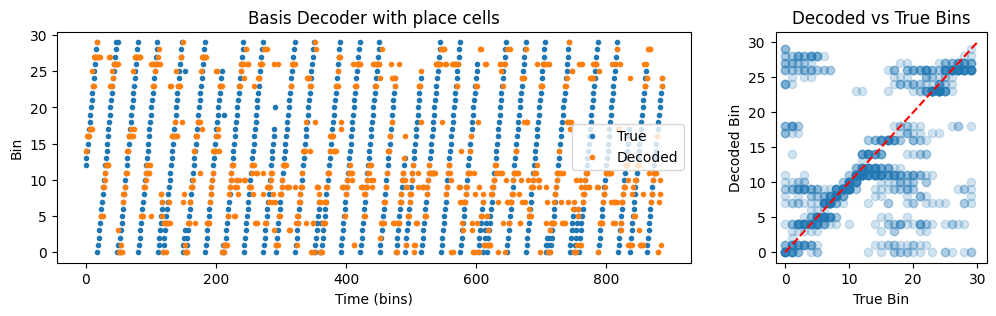

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={"width_ratios": [3, 1]})

ax1.set_title("Basis Decoder with place cells")
ax1.plot(df_subset["true_bin"], ".", lw=1, label="True")
ax1.plot(df_subset["decoded_bin"], ".", lw=1, label="Decoded")
ax1.set_xlabel("Time (bins)")
ax1.set_ylabel("Bin")
ax1.legend()#(loc=(1.04, 0.7))
#plt.savefig("..\\results\\20240903_Dc_1\\decoding_example.png", dpi=300, bbox_inches="tight")

ax2.plot([0, 30], [0, 30], "--", color="red")
ax2.scatter(df_subset["true_bin"], df_subset["decoded_bin"], alpha=0.2)
ax2.set_title("Decoded vs True Bins")
ax2.set_xlabel("True Bin")
ax2.set_ylabel("Decoded Bin")
plt.show()

In [ ]:
# Generate 1000 random guesses for each row
num_guesses = 1000
random_guesses = np.random.randint(0, 30, size=(len(df), num_guesses))
# Compute error (difference between true value and each guess)
error_matrix = random_guesses - df["true_bin"].values[:, None]

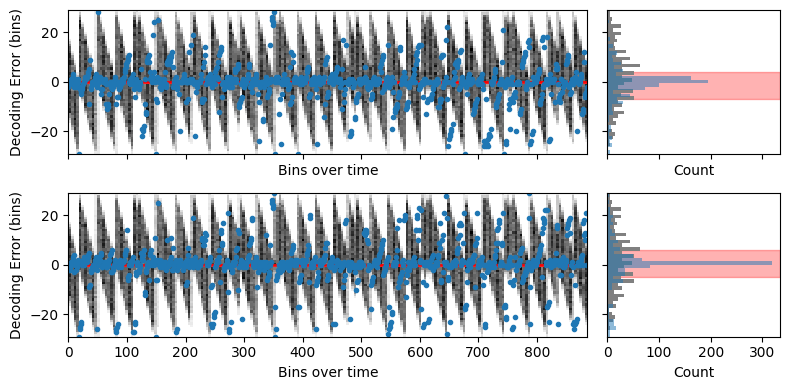

In [104]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 4), sharey='row', sharex='col', gridspec_kw={'width_ratios': [3, 1]})

# Plot error over time
ax1.hist2d(np.repeat(np.arange(len(df)), num_guesses), error_matrix.flatten(), bins=(200, 60), cmap="Greys", density=True)
ax1.hlines(0, 0, 900, "r", lw=2)
ax1.plot(df["true_bin"] - df["decoded_bin"], ".")
ax1.set_xlabel("Bins over time")
ax1.set_ylabel("Decoding Error (bins)")

# Plot histogram rotated and add shaded region
errors = df["true_bin"] - df["decoded_bin"]
counts, bins = np.histogram(errors, bins=40)

# Find the 90% confidence interval
sorted_errors = np.sort(errors)
lower_idx = int(len(sorted_errors) * 0.15)
upper_idx = int(len(sorted_errors) * 0.85)
ci_lower = sorted_errors[lower_idx]
ci_upper = sorted_errors[upper_idx]

# Add shaded region for 70% confidence interval
ax2.axhspan(ci_lower, ci_upper, color='red', alpha=0.3)
ax2.hist(error_matrix[:,0], bins=40, orientation='horizontal', color='gray')
ax2.hist(errors, bins=40, orientation='horizontal', alpha=0.5)
ax2.set_ylim(ax1.get_ylim())  # Match y-axis limits
ax2.set_ylabel("")  # Remove y-label since it's shared
ax2.set_xlabel("Count")

# Plot error over time
ax3.hist2d(np.repeat(np.arange(len(df)), num_guesses), error_matrix.flatten(), bins=(200, 60), cmap="Greys", density=True)
ax3.hlines(0, 0, 900, "r", lw=2)
ax3.plot(df_subset["true_bin"] - df_subset["decoded_bin"], ".")
ax3.set_xlabel("Bins over time")
ax3.set_ylabel("Decoding Error (bins)")

# Plot histogram rotated and add shaded region
errors = df_subset["true_bin"] - df_subset["decoded_bin"]
counts, bins = np.histogram(errors, bins=40)

# Find the 90% confidence interval
sorted_errors = np.sort(errors)
lower_idx = int(len(sorted_errors) * 0.15)
upper_idx = int(len(sorted_errors) * 0.85)
ci_lower = sorted_errors[lower_idx]
ci_upper = sorted_errors[upper_idx]

# Add shaded region for 70% confidence interval
ax4.axhspan(ci_lower, ci_upper, color='red', alpha=0.3)
ax4.hist(error_matrix[:,0], bins=40, orientation='horizontal', color='gray')
ax4.hist(errors, bins=40, orientation='horizontal', alpha=0.5)
ax4.set_ylim(ax1.get_ylim())  # Match y-axis limits
ax4.set_ylabel("")  # Remove y-label since it's shared
ax4.set_xlabel("Count")

plt.tight_layout()

#plt.savefig("..\\results\\20240903_Dc_1\\decoding_error_5neurons.png", dpi=300)

plt.show()

In [105]:
from scipy.stats import wilcoxon, mannwhitneyu

# Significance tests for full model
# Compute errors
actual_errors = df["true_bin"] - df["decoded_bin"]
random_errors = error_matrix

# Flatten the random error matrix for statistical comparison
random_errors_flat = random_errors.flatten()

# Perform Wilcoxon signed-rank test (paired test)
wilcoxon_result = wilcoxon(actual_errors, random_errors_flat[:len(actual_errors)])

# Perform Mann-Whitney U test (independent test)
mannwhitney_result = mannwhitneyu(actual_errors, random_errors_flat, alternative="two-sided")

# Display results
print(wilcoxon_result) 
print(mannwhitney_result)

# Significance tests for subset model
# Compute errors
actual_errors_subset = df_subset["true_bin"] - df_subset["decoded_bin"]

# Perform Wilcoxon signed-rank test (paired test)
wilcoxon_result_subset = wilcoxon(actual_errors_subset, random_errors_flat[:len(actual_errors_subset)])

# Perform Mann-Whitney U test (independent test)
mannwhitney_result_subset = mannwhitneyu(actual_errors_subset, random_errors_flat, alternative="two-sided")

# Display results
print(wilcoxon_result_subset) 
print(mannwhitney_result_subset)

WilcoxonResult(statistic=np.float64(130073.0), pvalue=np.float64(4.88341900090255e-15))
MannwhitneyuResult(statistic=np.float64(346282572.0), pvalue=np.float64(6.609499509812175e-10))
WilcoxonResult(statistic=np.float64(145541.5), pvalue=np.float64(1.6639200961846246e-07))
MannwhitneyuResult(statistic=np.float64(367435862.0), pvalue=np.float64(0.0006691376017833256))


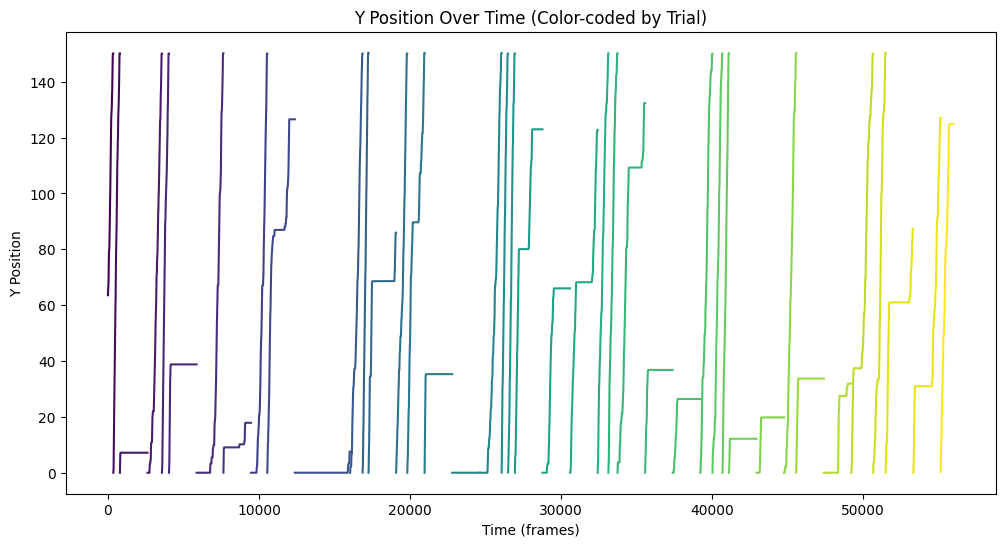

In [ ]:
def plot_trials(behavior):
    """
    Plots the Y position over time, color-coded by trial.

    Parameters:
        behavior (DataFrame): Must contain 'Y' (position in corridor) and 'trial' columns.
    """
    plt.figure(figsize=(12, 6))

    # Get unique trials and generate a color map
    unique_trials = behavior["trial"].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_trials)))

    # Plot Y positions, color-coded by trial
    for trial, color in zip(unique_trials, colors):
        trial_mask = behavior["trial"] == trial
        plt.plot(behavior.index[trial_mask], behavior["Y"][trial_mask], color=color, label=f"Trial {trial}")

    plt.xlabel("Time (frames)")
    plt.ylabel("Y Position")
    plt.title("Y Position Over Time (Color-coded by Trial)")
    #plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.show()
    
plot_trials(bh)

In [18]:
dffnp = dff.to_numpy()
bhnp = bh[["X", "Y", "trial"]].to_numpy()

In [82]:
min_value, max_value = bhnp[:,1].min() , bhnp[:,1].max()

np.where(np.diff(bhnp[:,1])<-1)

(array([  353,   790,   791,  2620,  3576,  3577,  4044,  5872,  7647,
         7648,  9475,  9476, 10554, 10555, 12382, 12383, 16037, 16038,
        16866, 16867, 17258, 17259, 19086, 19087, 19824, 19825, 20973,
        22800, 22801, 26072, 26073, 26501, 26502, 26954, 26955, 28782,
        28783, 30609, 30610, 32437, 33147, 33148, 33753, 35581, 37408,
        37409, 39236, 40041, 40042, 40704, 41132, 42959, 42960, 44787,
        45588, 45589, 47416, 47417, 49244, 50682, 50683, 51507, 51508,
        53335, 55162, 55163]),)

In [44]:
bin_edges = np.linspace(min_value, max_value, 31)

bin_input = bhnp[:,1]
digit_array = np.digitize(bin_input, bin_edges, right=False)
digit_array

# Assuming bh[:,1] contains the corridor identifiers
unique_bins = np.array([bin_val + 30 if corridor != 0 else bin_val for bin_val, corridor in zip(digit_array, bhnp[:, 0])])

    # Step 1: Find segment boundaries
change_indices = np.where(np.diff(unique_bins) != 0)[0] + 1  # Find where bins change
segment_splits = np.split(np.arange(len(unique_bins)), change_indices)  # Group indices by segment

    # Step 2: Compute averages for each segment
averaged_features = np.array([dffnp[segment].mean(axis=0) for segment in segment_splits])




In [86]:
import spatialinfo.decoder as dc

dff_clean, bh_clean = dc.clean_data(dff.to_numpy(), bh.to_numpy())


array([[0.03407812448445033, 0.09202163954933242, 0.055768610427270084,
        ..., 0.07118052089343195, 0.1760273613501232,
        0.06229270018636809],
       [0.02826725903855688, 0.08469950771079429, 0.04626320210170456,
        ..., 0.06661849305023759, 0.14450857284010343,
        0.04763849590359425],
       [0.022707357660265916, 0.0776002120340143, 0.036928560725224734,
        ..., 0.06241321846805544, 0.1143078716898466,
        0.03352228387744745],
       ...,
       [0.06380187760796883, 0.09488817777104173, 0.056638760812136354,
        ..., 0.06880155062575696, 0.047574316588300136,
        0.026248729205633627],
       [0.07550434325040876, 0.10985284551088834, 0.05449866137662086,
        ..., 0.07667313877537571, 0.04841574440313648,
        0.024258515375633533],
       [0.08789521808062968, 0.1254437141547942, 0.052428529449158816,
        ..., 0.0846913418065598, 0.049835032144417854,
        0.022102087215059886]], dtype=object)